<a href="https://colab.research.google.com/github/jenboland/DailyKnowledge/blob/master/Another_copy_of_MMM_pymc_Dec2024_spend_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymc_marketing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.6/174.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.6/484.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.0 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.26.3
    Uninstalling pytensor-2.26.3:
      Successfully uninstalled pytensor-2.26.3
  Attempting uninstall: pymc
    Found existing installation: pymc 5.18.2
    Uninstalling pymc-5.18.2:
      Successfully uninstalled pymc-5.18.2


In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_ = "/content/drive/MyDrive/Colab Notebooks/"

In [6]:
bing = pd.read_csv(path_+'cafb_bing_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
dm = pd.read_csv(path_+'cafb_direct_mail_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
email = pd.read_csv(path_+'cafb_email_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
fb = pd.read_csv(path_+'cafb_facebook_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
paid_search = pd.read_csv(path_+'cafb_google_paid_search.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
prog = pd.read_csv(path_+'cafb_programmatic_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
sales = pd.read_csv(path_+'cafb_transactions.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
ftf = pd.read_excel(path_+'CAFB MMM Telefundraising Data 2022-2024v2.xlsx', sheet_name = 'transposed', parse_dates=['timestamp']).fillna(0).rename(columns={'timestamp':'Date'}).set_index('Date').resample('W').sum()

fb = fb.rename(columns={'Impressions':'FB_Impressions', 'Spend':'FB_Spend'})
ftf = ftf.rename(columns={'calls':'FTF_Impressions', 'funds':'FTF_Spend'})

In [7]:
df = pd.concat([bing, dm, email, fb, paid_search, prog, ftf ,sales], axis=1).fillna(0).head(144)

In [8]:
df

,Bing_Branded_Impressions,Bing_Branded_Spend,Bing_NonBranded_Impressions,Bing_NonBranded_Spend,DM_Spend,DM_Impressions,Email_Impressions,Email_Spend,FB_Spend,FB_Impressions,GoogleAds_Branded_Impressions,GoogleAds_Branded_Spend,GoogleAds_NonBranded_Impressions,GoogleAds_NonBranded_Spend,Programatic_Spend,Programatic_Impressions,FTF_Spend,FTF_Impressions,contacts,Revenue
Date,,,,,,,,,,,,,,,,,,,,
2022-01-02,1.0,3.26,3852.0,210.97,0.0,0.0,0.0,0.0,0.00,0.0,147.0,86.760000,1365.0,196.730000,0.00,0.0,0.0,0.0,0.0,44191.70
2022-01-09,64.0,8.25,4482.0,757.49,0.0,0.0,0.0,0.0,0.00,0.0,806.0,496.890000,7085.0,1300.330000,0.00,0.0,3036.0,6487.0,561.0,99989.50
2022-01-16,11.0,7.87,5217.0,823.99,0.0,0.0,0.0,0.0,0.00,0.0,866.0,265.980000,6520.0,1251.740000,0.00,0.0,7176.0,10886.0,914.0,147772.39
2022-01-23,31.0,20.69,9084.0,834.35,0.0,0.0,111374.0,1000.0,0.00,0.0,908.0,146.240000,5910.0,911.130000,0.00,0.0,1656.0,1378.0,99.0,134056.43
2022-01-30,19.0,22.09,11871.0,835.66,0.0,0.0,0.0,0.0,0.00,0.0,722.0,154.490000,6567.0,1181.790000,0.00,0.0,4140.0,3511.0,507.0,229189.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,137.0,223.57,768.0,493.42,0.0,0.0,0.0,0.0,1284.14,373499.0,786.0,704.878583,4048.0,1500.009348,840.42,243539.0,0.0,0.0,0.0,156221.84
2024-09-08,174.0,245.35,424.0,410.70,0.0,0.0,0.0,0.0,1282.05,389795.0,816.0,801.801360,4090.0,1334.002493,829.75,282064.0,0.0,0.0,0.0,199752.84
2024-09-15,208.0,224.73,362.0,434.44,0.0,0.0,0.0,0.0,1284.53,364030.0,836.0,522.223274,4093.0,1083.907463,822.62,274108.0,0.0,0.0,0.0,162318.56


In [9]:
input_df = df[['Revenue', *[c for c in df.columns if 'Impressions' in c]]]
spend_df = df[['Revenue', *[c for c in df.columns if 'Spend' in c]]]

In [10]:
input_df

,Revenue,Bing_Branded_Impressions,Bing_NonBranded_Impressions,DM_Impressions,Email_Impressions,FB_Impressions,GoogleAds_Branded_Impressions,GoogleAds_NonBranded_Impressions,Programatic_Impressions,FTF_Impressions
Date,,,,,,,,,,
2022-01-02,44191.70,1.0,3852.0,0.0,0.0,0.0,147.0,1365.0,0.0,0.0
2022-01-09,99989.50,64.0,4482.0,0.0,0.0,0.0,806.0,7085.0,0.0,6487.0
2022-01-16,147772.39,11.0,5217.0,0.0,0.0,0.0,866.0,6520.0,0.0,10886.0
2022-01-23,134056.43,31.0,9084.0,0.0,111374.0,0.0,908.0,5910.0,0.0,1378.0
2022-01-30,229189.84,19.0,11871.0,0.0,0.0,0.0,722.0,6567.0,0.0,3511.0
...,...,...,...,...,...,...,...,...,...,...
2024-09-01,156221.84,137.0,768.0,0.0,0.0,373499.0,786.0,4048.0,243539.0,0.0
2024-09-08,199752.84,174.0,424.0,0.0,0.0,389795.0,816.0,4090.0,282064.0,0.0
2024-09-15,162318.56,208.0,362.0,0.0,0.0,364030.0,836.0,4093.0,274108.0,0.0


In [11]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

df = spend_df.copy()
df = df.reset_index()

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['dayofyear'] = df['Date'].dt.dayofyear

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 144


In [12]:
df

,Date,Revenue,Bing_Branded_Spend,Bing_NonBranded_Spend,DM_Spend,Email_Spend,FB_Spend,GoogleAds_Branded_Spend,GoogleAds_NonBranded_Spend,Programatic_Spend,FTF_Spend,year,month,dayofyear
0,2022-01-02,44191.70,3.26,210.97,0.0,0.0,0.00,86.760000,196.730000,0.00,0.0,2022,1,2
1,2022-01-09,99989.50,8.25,757.49,0.0,0.0,0.00,496.890000,1300.330000,0.00,3036.0,2022,1,9
2,2022-01-16,147772.39,7.87,823.99,0.0,0.0,0.00,265.980000,1251.740000,0.00,7176.0,2022,1,16
3,2022-01-23,134056.43,20.69,834.35,0.0,1000.0,0.00,146.240000,911.130000,0.00,1656.0,2022,1,23
4,2022-01-30,229189.84,22.09,835.66,0.0,0.0,0.00,154.490000,1181.790000,0.00,4140.0,2022,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024-09-01,156221.84,223.57,493.42,0.0,0.0,1284.14,704.878583,1500.009348,840.42,0.0,2024,9,245
140,2024-09-08,199752.84,245.35,410.70,0.0,0.0,1282.05,801.801360,1334.002493,829.75,0.0,2024,9,252
141,2024-09-15,162318.56,224.73,434.44,0.0,0.0,1284.53,522.223274,1083.907463,822.62,0.0,2024,9,259
142,2024-09-22,163221.03,70.10,25.06,0.0,0.0,1286.55,699.757306,1095.917809,355.87,0.0,2024,9,266


In [13]:
df["gt_2023"] = (df["Date"] == "2023-12-03").astype(float)
df["gt_2022"] = (df["Date"] == "2022-12-04").astype(float)
df["eoy_2023"] = (df["Date"] == "2023-12-31").astype(float)
df["eoy_2022"] = (df["Date"] == "2023-01-01").astype(float)

In [14]:
df['trend'] = df['Revenue'].shift(1).fillna(method="bfill")

In [15]:
# trend feature
data = df.copy()

#data["t"] = range(n)

data.head()

,Date,Revenue,Bing_Branded_Spend,Bing_NonBranded_Spend,DM_Spend,Email_Spend,FB_Spend,GoogleAds_Branded_Spend,GoogleAds_NonBranded_Spend,Programatic_Spend,FTF_Spend,year,month,dayofyear,gt_2023,gt_2022,eoy_2023,eoy_2022,trend
0,2022-01-02,44191.70,3.26,210.97,0.0,0.0,0.0,86.76,196.73,0.0,0.0,2022,1,2,0.0,0.0,0.0,0.0,44191.70
1,2022-01-09,99989.50,8.25,757.49,0.0,0.0,0.0,496.89,1300.33,0.0,3036.0,2022,1,9,0.0,0.0,0.0,0.0,44191.70
2,2022-01-16,147772.39,7.87,823.99,0.0,0.0,0.0,265.98,1251.74,0.0,7176.0,2022,1,16,0.0,0.0,0.0,0.0,99989.50
3,2022-01-23,134056.43,20.69,834.35,0.0,1000.0,0.0,146.24,911.13,0.0,1656.0,2022,1,23,0.0,0.0,0.0,0.0,147772.39
4,2022-01-30,229189.84,22.09,835.66,0.0,0.0,0.0,154.49,1181.79,0.0,4140.0,2022,1,30,0.0,0.0,0.0,0.0,134056.43


In [16]:
spend_df.columns

Index(['Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend'],
      dtype='object')

In [17]:
spend_df[[ 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend','FTF_Spend']].sum(axis=0)

,0
Bing_Branded_Spend,2.122165e+04
Bing_NonBranded_Spend,5.996311e+04
DM_Spend,1.596722e+06
Email_Spend,4.600000e+04
FB_Spend,2.432722e+04
GoogleAds_Branded_Spend,4.170892e+04
GoogleAds_NonBranded_Spend,7.533248e+04
Programatic_Spend,3.537012e+04
FTF_Spend,2.305580e+05


In [18]:
total_spend_per_channel = spend_df[[ 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend','FTF_Spend']].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share

,0
Bing_Branded_Spend,0.009958
Bing_NonBranded_Spend,0.028136
DM_Spend,0.749211
Email_Spend,0.021584
FB_Spend,0.011415
GoogleAds_Branded_Spend,0.019571
GoogleAds_NonBranded_Spend,0.035347
Programatic_Spend,0.016596
FTF_Spend,0.108182


In [19]:
spend_df.columns

Index(['Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend'],
      dtype='object')

In [20]:
n_channels = 8

prior_sigma = n_channels * spend_share.to_numpy()

prior_sigma.tolist()

[0.0796607174036519,
 0.22508637925675393,
 5.993691348891055,
 0.17267238883724814,
 0.09131824328628868,
 0.15656476810367237,
 0.2827791164083207,
 0.13277050247522013,
 0.8654565353377882]

In [21]:
X = data.drop("Revenue", axis=1)
y = data["Revenue"]

In [22]:
X.gt_2023.unique()

array([0., 1.])

In [23]:
dummy_model = MMM(
    date_column="",
    channel_columns=[""],
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
)
dummy_model.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [24]:
my_model_config = {
    "intercept": {"dist": "Normal", "kwargs": {"mu": 0, "sigma": 0.5}},
    "saturation_beta": {
        "dist": "HalfNormal",
        "kwargs": {"sigma": prior_sigma},
    },
    "gamma_control": {
        "dist": "Normal",
        "kwargs": {"mu": 0, "sigma": 0.05},
    },
    "gamma_fourier": {
        "dist": "Laplace",
        "kwargs": {"mu": 0, "b": 0.2},
    },
    "likelihood": {
        "dist": "Normal",
        "kwargs": {
            "sigma": {"dist": "Exponential", "kwargs": {"lam": 1 / 10}}
            # Also possible define sigma as:
            # {'sigma': 5}
        },
    },
}

In [25]:
my_sampler_config = {"progressbar": True}

In [26]:
data.columns

Index(['Date', 'Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend',
       'DM_Spend', 'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend', 'year',
       'month', 'dayofyear', 'gt_2023', 'gt_2022', 'eoy_2023', 'eoy_2022',
       'trend'],
      dtype='object')

In [27]:
mmm = MMM(
    model_config=my_model_config,
    sampler_config=my_sampler_config,
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=['Bing_Branded_Spend', 'Bing_NonBranded_Spend',
       'DM_Spend', 'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend','FTF_Spend'],
    control_columns=[
        'gt_2023',
       'gt_2022', 'eoy_2023', 'eoy_2022', 'trend'
    ],
    yearly_seasonality=2,
)

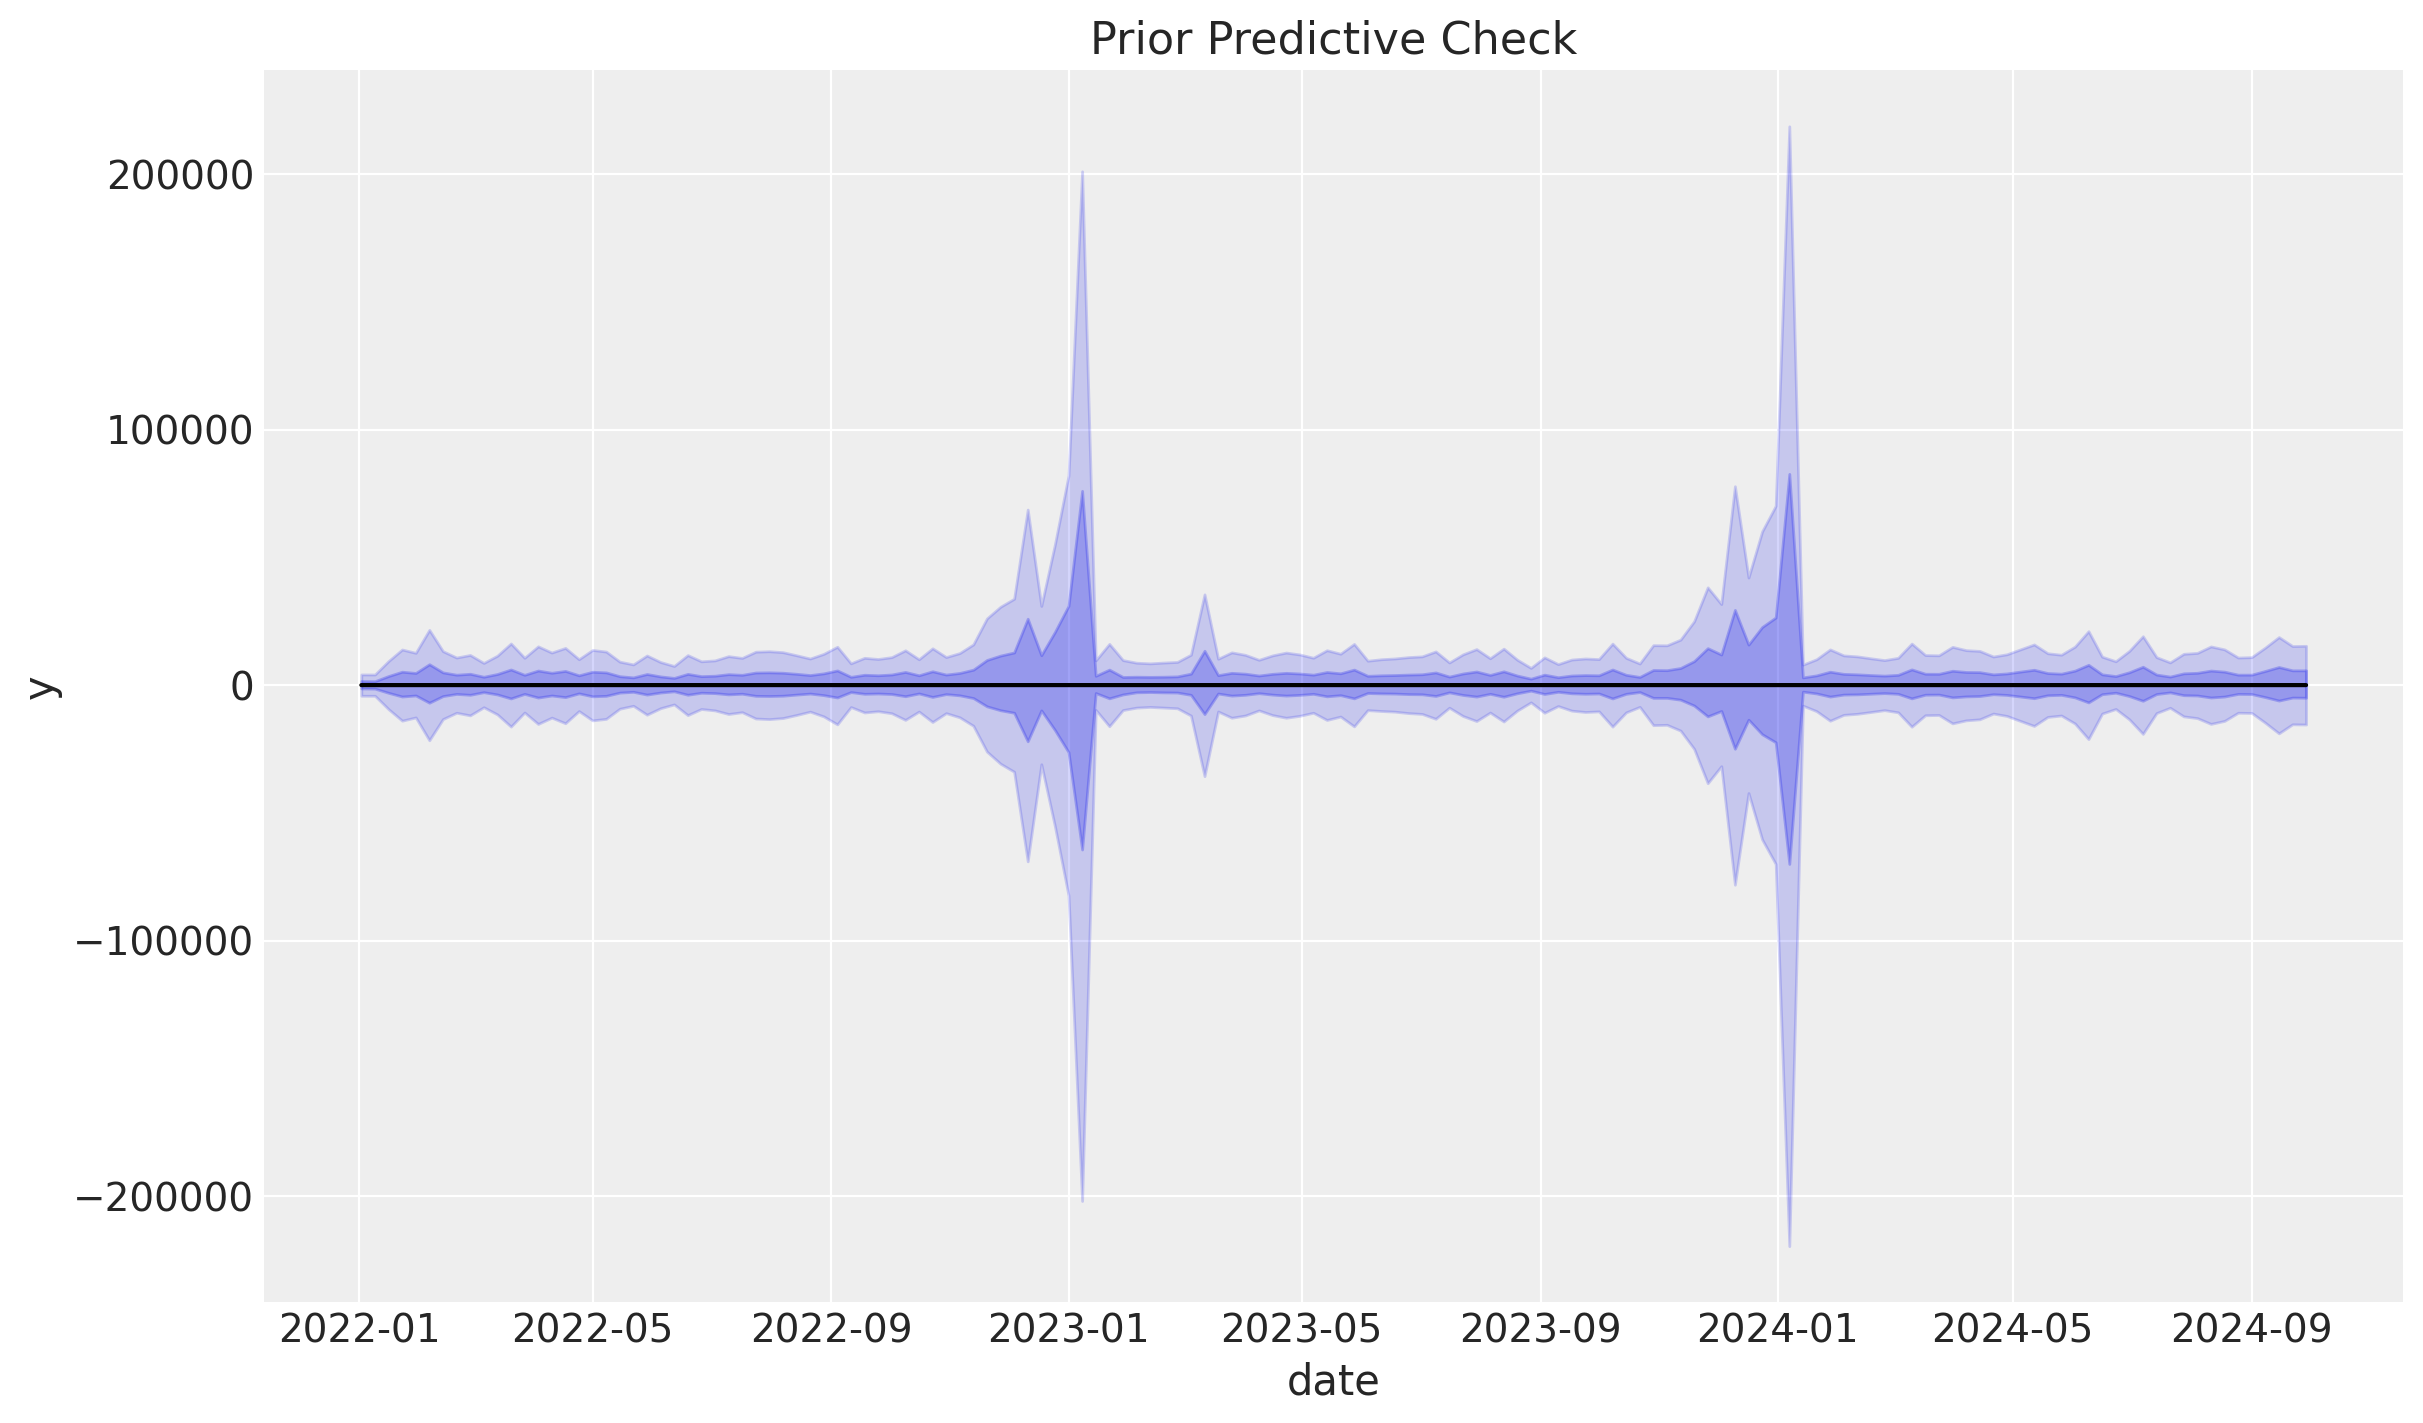

In [28]:
# Generate prior predictive samples
mmm.sample_prior_predictive(X, y, samples=2_000)

mmm.plot_prior_predictive();

In [29]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [30]:
mmm.fit(X=X, y=y, target_accept=0.95, chains=4, random_seed=rng)

Output()

Output()

Output()

Output()

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

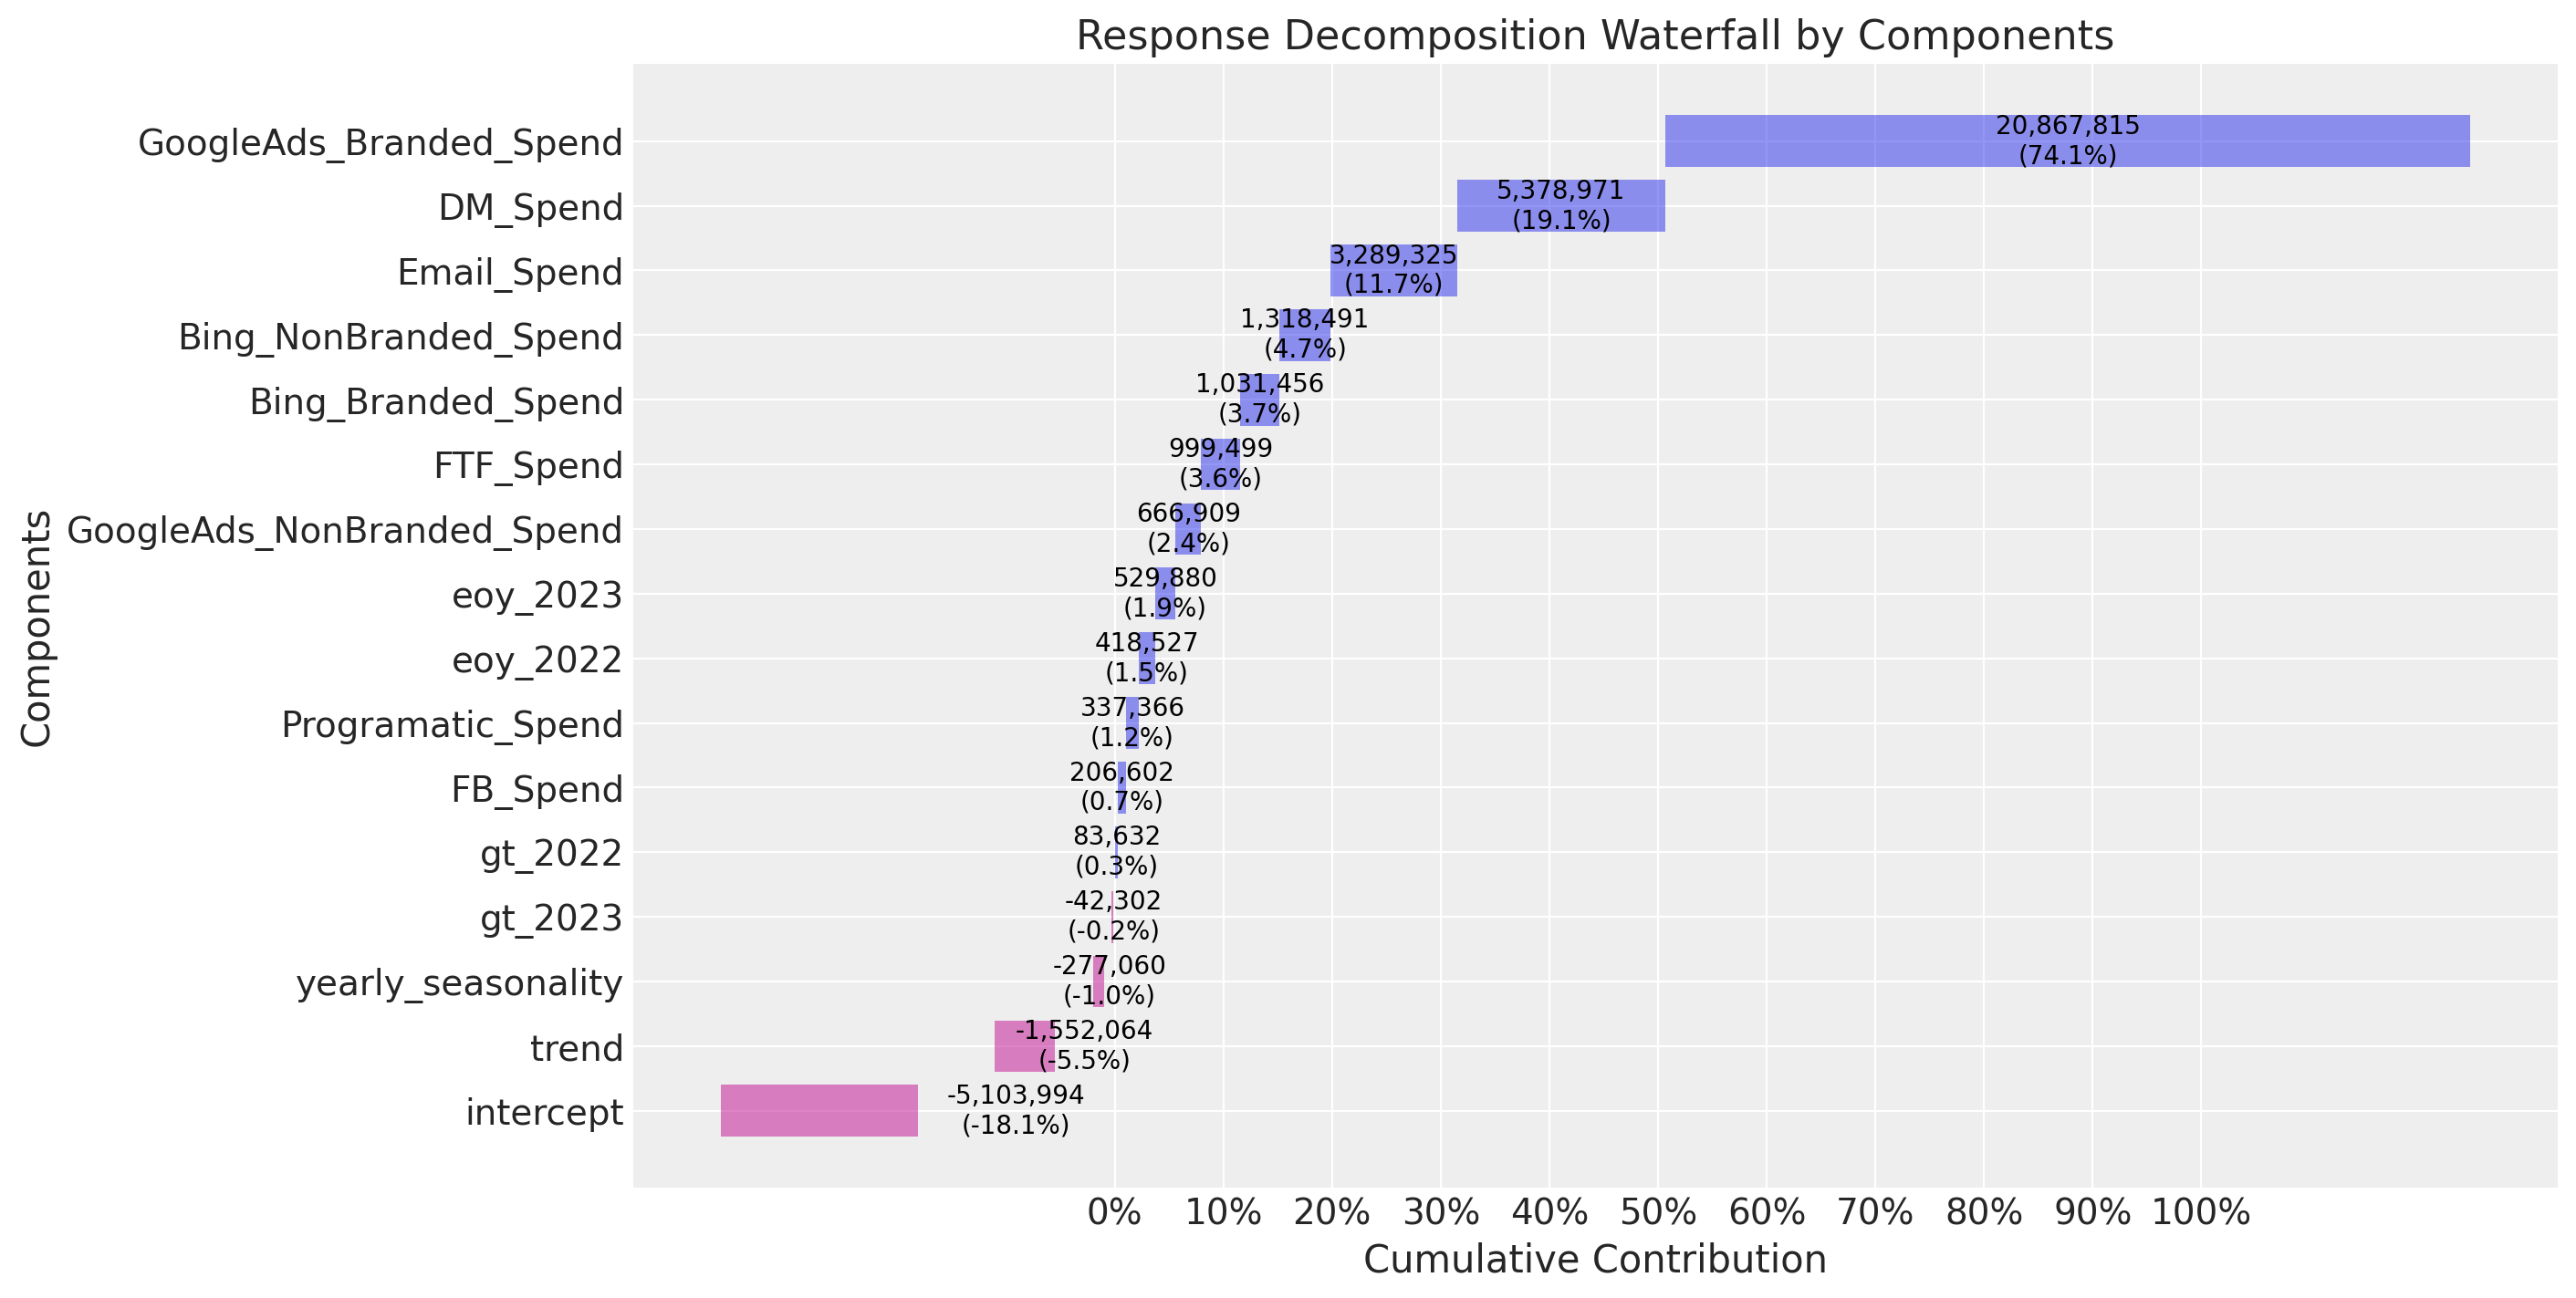

In [31]:
mmm.plot_waterfall_components_decomposition();

In [32]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
)

get_mean_contributions_over_time_df.head()

,Bing_Branded_Spend,Bing_NonBranded_Spend,DM_Spend,Email_Spend,FB_Spend,GoogleAds_Branded_Spend,GoogleAds_NonBranded_Spend,Programatic_Spend,FTF_Spend,gt_2023,gt_2022,eoy_2023,eoy_2022,trend,yearly_seasonality,intercept
date,,,,,,,,,,,,,,,,
2022-01-02,135.087864,3769.397815,0.0,0.000000,0.0,43626.612796,1529.092359,0.0,0.000000,0.0,0.0,0.0,0.0,-2439.480417,54058.092362,-35444.402121
2022-01-09,364.472372,12965.108495,0.0,0.000000,0.0,248726.178436,7982.889887,0.0,9121.803546,0.0,0.0,0.0,0.0,-2439.480417,50944.164340,-35444.402121
2022-01-16,390.097467,15656.139320,0.0,0.000000,0.0,138839.195474,8823.960701,0.0,23278.230086,0.0,0.0,0.0,0.0,-5519.643443,46333.428256,-35444.402121
2022-01-23,931.359023,16643.165533,0.0,67040.937450,0.0,76612.952279,7830.636198,0.0,11598.004639,0.0,0.0,0.0,0.0,-8157.365559,40522.081295,-35444.402121
2022-01-30,1082.680358,17083.914304,0.0,5877.634076,0.0,79361.767652,8757.949847,0.0,16618.384728,0.0,0.0,0.0,0.0,-7400.213971,33854.276529,-35444.402121


In [33]:
get_mean_contributions_over_time_df.sum().sum()

28153053.40721926

In [34]:
y.sum()

28155353.659999985

In [35]:
attr = get_mean_contributions_over_time_df.sum()/get_mean_contributions_over_time_df.sum().sum()*100
attr

,0
Bing_Branded_Spend,3.663743
Bing_NonBranded_Spend,4.683295
DM_Spend,19.106174
Email_Spend,11.683724
FB_Spend,0.733851
GoogleAds_Branded_Spend,74.122742
GoogleAds_NonBranded_Spend,2.368869
Programatic_Spend,1.198328
FTF_Spend,3.550235
gt_2023,-0.150257


In [36]:
attr.loc[['trend','intercept','yearly_seasonality','gt_2022','gt_2023','eoy_2022','eoy_2023']].sum()

-21.110961843623866

In [37]:
X.columns

Index(['Date', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend', 'year',
       'month', 'dayofyear', 'gt_2023', 'gt_2022', 'eoy_2023', 'eoy_2022',
       'trend'],
      dtype='object')